# Numerical Regression — MLP & RNN + SHAP + STAT‑XAI


This notebook trains **either** an MLP or an RNN on a *numerical-only regression* dataset,
then computes **SHAP** explanations and **STAT‑XAI** (main, pairwise, final) statistics. 
It also computes **precision, recall, FDR, and top‑1 match** for feature recovery using SHAP and STAT‑XAI rankings.

---
**How to use**
1. Put your CSV at `data/Numerical_Features_Continuous_Outcome.csv` (or change `DATA_PATH`).
2. Choose `MODEL = "MLP"` or `"RNN"`.
3. Define your ground‑truth set `GT` (feature names) for recovery metrics.
4. Run all cells.

In [2]:
# ==== Config ====
import os
DATA_PATH = "/Users/arsh/STAT-XAI/Datasets/Synthetic/Numerical Features Continous Outcome.csv"  # <-- change to your CSV path
MODEL = "MLP"  # "MLP" or "RNN"

# Output folders
ROOT_DIR = "outputs_num_reg"
PLOTS_DIR = os.path.join(ROOT_DIR, "plots")
TABLES_DIR = os.path.join(ROOT_DIR, "tables")
SHAP_DIR = os.path.join(ROOT_DIR, "shap")

os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(TABLES_DIR, exist_ok=True)
os.makedirs(SHAP_DIR, exist_ok=True)
print("Saving to:", ROOT_DIR)

Saving to: outputs_num_reg


In [4]:
# ==== Imports ====
import os, itertools, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.neural_network import MLPRegressor

import shap
import statsmodels.formula.api as smf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams["figure.dpi"] = 120

In [6]:
# ==== Load & Prepare Data ====
df = pd.read_csv(DATA_PATH)
# Drop unnamed/index-like first column if present
if df.columns[0].lower().startswith("unnamed"):
    df = df.drop(columns=[df.columns[0]])

# Rename target if needed: expecting 'Loan_Approval' as continuous
TARGET = "Loan_Approval"
if TARGET not in df.columns:
    for cand in ["Approval_Probability", "target", "y"]:
        if cand in df.columns:
            TARGET = cand
            break

X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].astype(float).copy()

# Numeric only
X = X.select_dtypes(include=[np.number])
num_cols = X.columns.tolist()
print("Numeric features:", num_cols)
print("Target column:", TARGET)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# IQR outlier filtering on train only
Q1 = X_train.quantile(0.25); Q3 = X_train.quantile(0.75); IQR = Q3 - Q1
mask = ~((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1)
X_train = X_train[mask]; y_train = y_train.loc[X_train.index]

# Scale
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

Numeric features: ['Annual_Income', 'Credit_Score', 'Debt_to_Income', 'Employment_Length', 'Age']
Target column: Loan_Approval


In [ ]:
# ==== Models ====
class TabularSeqDataset(Dataset):
    """X: [N, D] → return [N, D, 1] to be "sequence" for RNN"""
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(np.asarray(y)).float().reshape(-1,1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return self.X[i].unsqueeze(-1), self.y[i]

class TabularRNN(nn.Module):
    def __init__(self, hidden_size=32, num_layers=1, bidirectional=False):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True,
                          bidirectional=bidirectional)
        d = 2 if bidirectional else 1
        self.head = nn.Linear(hidden_size*d, 1)
    def forward(self, x):
        out, h_n = self.rnn(x)
        last = h_n[-1]
        return self.head(last)

In [8]:
# ==== Train & Predict ====
if MODEL.upper() == "MLP":
    mlp = MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-3,
        learning_rate='adaptive',
        learning_rate_init=1e-3,
        max_iter=500,
        shuffle=True,
        random_state=1,
    )
    mlp.fit(X_train_s, y_train)
    # Optional small loop just to echo losses
    train_losses, test_losses = [], []
    for epoch in range(10):
        mlp.fit(X_train_s, y_train)
        train_losses.append(mlp.loss_)
        preds = mlp.predict(X_test_s)
        test_losses.append(mean_squared_error(y_test, preds))
        print(f"Epoch {epoch+1:02d}: train loss={mlp.loss_:.5f}, test MSE={test_losses[-1]:.5f}")
    y_pred = mlp.predict(X_test_s)
    model_obj = mlp

elif MODEL.upper() == "RNN":
    # Prepare PyTorch loaders
    X_train_np, X_test_np = X_train_s.astype(np.float32), X_test_s.astype(np.float32)
    train_ds = TabularSeqDataset(X_train_np, y_train.values)
    test_ds  = TabularSeqDataset(X_test_np,  y_test.values)
    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    test_dl  = DataLoader(test_ds,  batch_size=32)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TabularRNN(hidden_size=32, num_layers=1).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(20):
        model.train(); tot=0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        model.eval()
        with torch.no_grad():
            val=0.0
            for xb, yb in test_dl:
                xb, yb = xb.to(device), yb.to(device)
                val += loss_fn(model(xb), yb).item() * xb.size(0)
        print(f"Epoch {epoch+1:02d}: train MSE={tot/len(train_ds):.6f}, val MSE={val/len(test_ds):.6f}")

    model.eval()
    with torch.no_grad():
        X_test_t = torch.from_numpy(X_test_np).float().unsqueeze(-1).to(device)
        y_pred = model(X_test_t).cpu().numpy().flatten()
    model_obj = model

else:
    raise ValueError("MODEL must be 'MLP' or 'RNN'")

Epoch 01: train loss=0.00031, test MSE=0.00019
Epoch 02: train loss=0.00031, test MSE=0.00019
Epoch 03: train loss=0.00031, test MSE=0.00019
Epoch 04: train loss=0.00031, test MSE=0.00019
Epoch 05: train loss=0.00031, test MSE=0.00019
Epoch 06: train loss=0.00031, test MSE=0.00019
Epoch 07: train loss=0.00031, test MSE=0.00019
Epoch 08: train loss=0.00031, test MSE=0.00019
Epoch 09: train loss=0.00031, test MSE=0.00019
Epoch 10: train loss=0.00031, test MSE=0.00019


In [10]:
# ==== Evaluation ====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"\nTest MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R^2 : {r2:.6f}")

merged_df = pd.DataFrame(X_test, columns=num_cols).reset_index(drop=True)
merged_df["Predicted_Label"] = y_pred
merged_df.head()


Test MSE : 0.000190
Test RMSE: 0.013769
Test MAE : 0.010918
Test R^2 : 0.995831


,Annual_Income,Credit_Score,Debt_to_Income,Employment_Length,Age,Predicted_Label
0,62060.319343,353.290689,0.968948,11.586947,45,0.416136
1,103673.003188,734.158798,0.195106,15.575252,25,0.643589
2,89270.104448,414.860361,0.989355,11.385730,23,0.624837
3,33381.071927,743.248106,0.128248,6.649651,34,0.263829
4,84826.122827,818.050800,0.354751,16.913153,75,0.687179


## SHAP — feature attributions

Mean |SHAP| per feature:
Annual_Income        0.112035
Credit_Score         0.106053
Debt_to_Income       0.096716
Employment_Length    0.002735
Age                  0.002637
dtype: float64


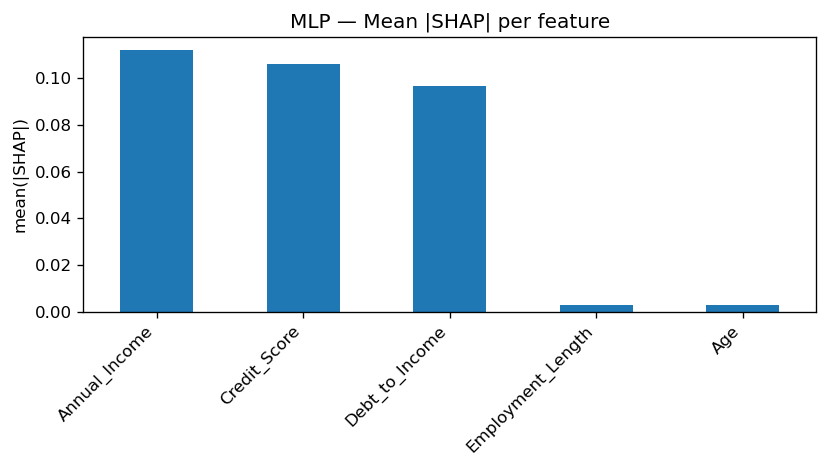

In [20]:
feature_names = num_cols

if MODEL.upper() == "MLP":
    explainer = shap.Explainer(lambda x: model_obj.predict(scaler.transform(pd.DataFrame(x, columns=feature_names))), 
                               pd.DataFrame(X_train.values, columns=feature_names))
    shap_vals = []
    batch = 1024
    Xtest_df = pd.DataFrame(X_test.values, columns=feature_names)
    for i in range(0, len(Xtest_df), batch):
        sv = explainer(Xtest_df.iloc[i:i+batch])
        shap_vals.append(sv.values)
    shap_values = np.vstack(shap_vals)

else:
    X_bg = pd.DataFrame(X_train.values, columns=feature_names).sample(min(100, len(X_train)), random_state=0)
    def rnn_predict(df_batch):
        arr = scaler.transform(df_batch.values.astype(np.float32))
        arr_t = torch.from_numpy(arr).float().unsqueeze(-1)
        model_obj.eval()
        with torch.no_grad():
            preds = model_obj(arr_t).cpu().numpy().flatten()
        return preds
    kexp = shap.KernelExplainer(rnn_predict, X_bg, link="identity")
    Xtest_df = pd.DataFrame(X_test.values, columns=feature_names).sample(min(300, len(X_test)), random_state=1)
    shap_values = kexp.shap_values(Xtest_df, nsamples=200)

mean_abs_shap = pd.Series(np.abs(shap_values).mean(axis=0), index=feature_names).sort_values(ascending=False)
print("Mean |SHAP| per feature:")
print(mean_abs_shap)

plt.figure(figsize=(7,4))
mean_abs_shap.plot.bar()
plt.xticks(rotation=45, ha='right'); plt.ylabel("mean(|SHAP|)")
plt.title(f"{MODEL} — Mean |SHAP| per feature")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, f"shap_mean_abs_{MODEL}.png"), dpi=300)
plt.show()

## STAT‑XAI — main, pairwise, final (numerical‑only)

In [12]:
from scipy.stats import pearsonr

ALPHA = 0.05

def statxai_numeric(df: pd.DataFrame, features: list, target: str):
    main_effects = {}
    rows = []
    for feat in features:
        r, p = pearsonr(df[feat], df[target])
        eff = r**2 if p < ALPHA else 0.0
        main_effects[feat] = float(eff)
        rows.append({"Feature": feat, "r": float(r), "p_value": float(p), "Effect Size (r^2)": float(eff)})
    main_df = pd.DataFrame(rows).sort_values("Effect Size (r^2)", ascending=False).reset_index(drop=True)

    pair_sums = {f: 0.0 for f in features}
    pairs = []
    for x, y in itertools.combinations(features, 2):
        red  = smf.ols(f"{target} ~ {x} + {y}", df).fit()
        full = smf.ols(f"{target} ~ {x} * {y}", df).fit()
        f_stat, p_int, _ = full.compare_f_test(red)
        dR2 = float(full.rsquared - red.rsquared)
        pairs.append({"Feature Pair": f"{x} × {y}", "p_value": float(p_int), "ΔR²": dR2, "Significant?": "Yes" if p_int < ALPHA else "No"})
        if p_int < ALPHA:
            pair_sums[x] += dR2; pair_sums[y] += dR2
    pairwise_df = pd.DataFrame(pairs).sort_values("ΔR²", ascending=False).reset_index(drop=True)

    finals = []
    for f in features:
        finals.append({"Feature": f,
                       "Main Effect (r^2)": float(main_effects.get(f,0.0)),
                       "Sum Interaction (ΔR²)": float(pair_sums.get(f,0.0)),
                       "Final Score": float(main_effects.get(f,0.0) + pair_sums.get(f,0.0))})
    final_df = pd.DataFrame(finals).sort_values("Final Score", ascending=False).reset_index(drop=True)
    return main_df, pairwise_df, final_df

main_df, pairwise_df, final_df = statxai_numeric(merged_df, num_cols, "Predicted_Label")

main_df.to_csv(os.path.join(TABLES_DIR, f"main_effects_{MODEL}.csv"), index=False)
pairwise_df.to_csv(os.path.join(TABLES_DIR, f"pairwise_interactions_{MODEL}.csv"), index=False)
final_df.to_csv(os.path.join(TABLES_DIR, f"final_scores_{MODEL}.csv"), index=False)

from IPython.display import display
print("Main effects (top):"); display(main_df.head(10))
print("Pairwise interactions (top):"); display(pairwise_df.head(10))
print("Final scores (top):"); display(final_df.head(10))

Main effects (top):


,Feature,r,p_value,Effect Size (r^2)
0,Annual_Income,0.607900,2.106415e-202,0.369543
1,Credit_Score,0.593230,1.966483e-190,0.351922
2,Debt_to_Income,0.524792,5.828663e-142,0.275406
3,Employment_Length,-0.015347,4.927543e-01,0.000000
4,Age,0.008931,6.897845e-01,0.000000


Pairwise interactions (top):


,Feature Pair,p_value,ΔR²,Significant?
0,Credit_Score × Employment_Length,0.069402,1.069586e-03,No
1,Debt_to_Income × Employment_Length,0.101984,9.695744e-04,No
2,Annual_Income × Employment_Length,0.558050,1.083066e-04,No
3,Credit_Score × Debt_to_Income,0.688620,3.067188e-05,No
4,Employment_Length × Age,0.821758,2.542544e-05,No
5,Debt_to_Income × Age,0.864483,1.057684e-05,No
6,Annual_Income × Age,0.865720,9.032577e-06,No
7,Credit_Score × Age,0.869317,8.790494e-06,No
8,Annual_Income × Credit_Score,0.922884,1.342337e-06,No
9,Annual_Income × Debt_to_Income,0.966999,2.994236e-07,No


Final scores (top):


,Feature,Main Effect (r^2),Sum Interaction (ΔR²),Final Score
0,Annual_Income,0.369543,0.0,0.369543
1,Credit_Score,0.351922,0.0,0.351922
2,Debt_to_Income,0.275406,0.0,0.275406
3,Employment_Length,0.000000,0.0,0.000000
4,Age,0.000000,0.0,0.000000


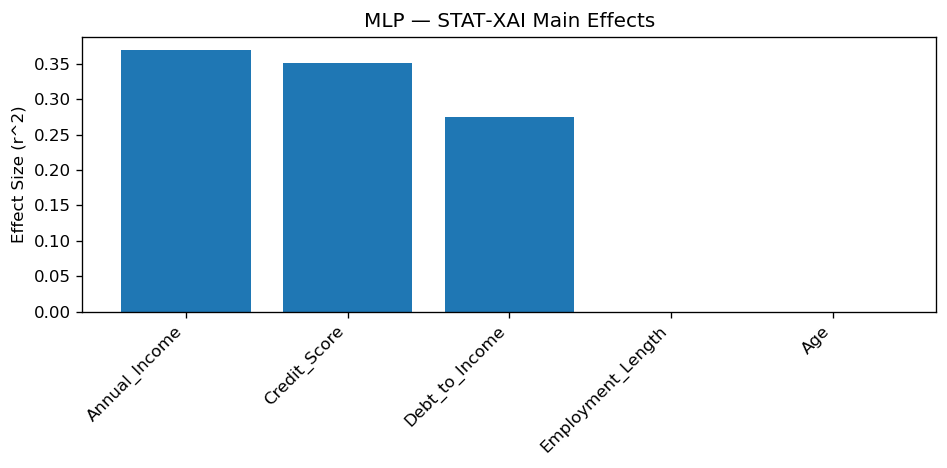

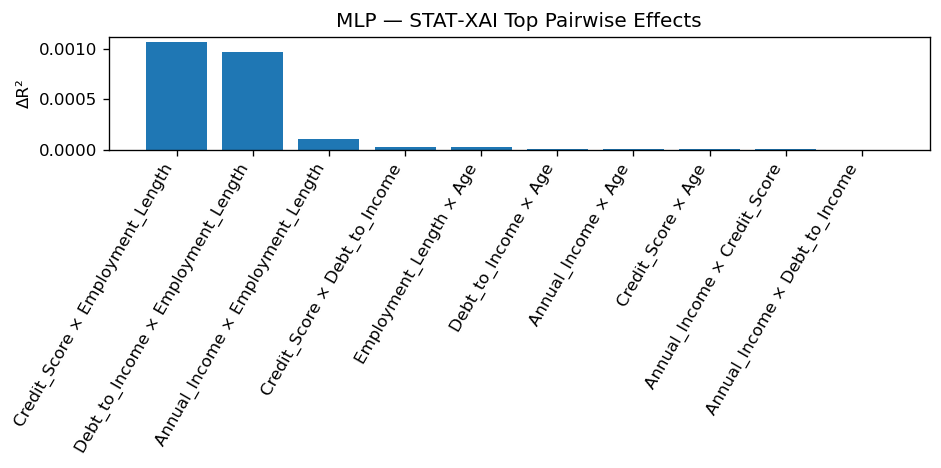

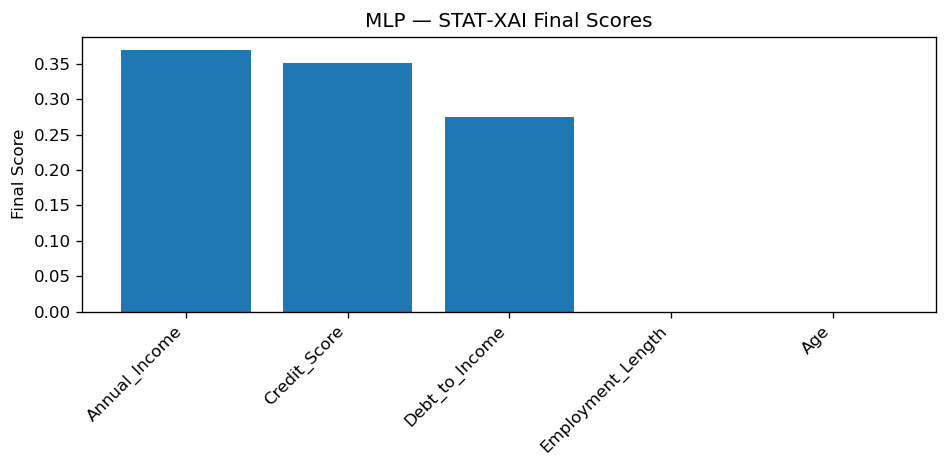

In [14]:
# ==== Plots: Main, Pairwise, Final ====
df1 = main_df.sort_values("Effect Size (r^2)", ascending=False)
plt.figure(figsize=(8,4))
plt.bar(df1["Feature"], df1["Effect Size (r^2)"])
plt.xticks(rotation=45, ha='right'); plt.ylabel("Effect Size (r^2)")
plt.title(f"{MODEL} — STAT‑XAI Main Effects")
plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR, f"main_effects_{MODEL}.png"), dpi=300)
plt.show()

df2 = pairwise_df.dropna(subset=["ΔR²"]).sort_values("ΔR²", ascending=False).head(15)
if not df2.empty:
    plt.figure(figsize=(8,4))
    plt.bar(df2["Feature Pair"], df2["ΔR²"])
    plt.xticks(rotation=60, ha='right'); plt.ylabel("ΔR²")
    plt.title(f"{MODEL} — STAT‑XAI Top Pairwise Effects")
    plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR, f"pairwise_effects_{MODEL}.png"), dpi=300)
    plt.show()

df3 = final_df.sort_values("Final Score", ascending=False)
plt.figure(figsize=(8,4))
plt.bar(df3["Feature"], df3["Final Score"])
plt.xticks(rotation=45, ha='right'); plt.ylabel("Final Score")
plt.title(f"{MODEL} — STAT‑XAI Final Scores")
plt.tight_layout(); plt.savefig(os.path.join(PLOTS_DIR, f"final_effects_{MODEL}.png"), dpi=300)
plt.show()

In [24]:
# ==== Feature‑recovery metrics ====
GT = {"Annual_Income", "Credit_Score", "Employment_Length"}
def metrics_from_ranking(gt_set, ranking):
    gt = set(gt_set)
    r  = list(ranking)
    tp = gt & set(r)
    fp = set(r) - gt
    fn = gt - set(r)
    precision = len(tp)/ (len(tp)+len(fp)) if (len(tp)+len(fp)) else 0.0
    recall    = len(tp)/ len(gt) if len(gt) else 0.0
    fdr       = len(fp)/ (len(tp)+len(fp)) if (len(tp)+len(fp)) else 0.0
    top1      = 1 if (len(r)>0 and r[0] in gt) else 0
    return {"Precision": precision, "Recall": recall, "FDR": fdr, "Top-1 Match": top1,
            "TP": sorted(list(tp)), "FP": sorted(list(fp)), "FN": sorted(list(fn))}

shap_rank = mean_abs_shap.index.tolist()
statxai_rank = final_df.sort_values("Final Score", ascending=False)["Feature"].tolist()

m_shap = metrics_from_ranking(GT, shap_rank)
m_stat = metrics_from_ranking(GT, statxai_rank)

